# Weedle's Cave
Weedle's Cave is a kaggle competition that can be found here: https://www.kaggle.com/terminus7/pokemon-challenge. <br/><br/>
The goal is to predict the outcome of a pokemon battle given 2 pokemon. Our training set has the history of previous pokemon battles and who was the victor. In addition, there's a csv provided with the stats of every pokemon.<br/><br/>
My childhood domain knowledge may come in handy for this dataset so let's predict them all!

In [40]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from itertools import combinations

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline, make_union
from sklearn.base import BaseEstimator, TransformerMixin

%matplotlib inline

### Import

In [2]:
combat_df = pd.read_csv('./dataset/combats.csv')
pokemon_df = pd.read_csv('./dataset/pokemon.csv')
test_df = pd.read_csv('./dataset/test.csv')

### EDA

In [3]:
# What the dataframes look like
print(combat_df.head())
print('')
print(pokemon_df.head())

   First_pokemon  Second_pokemon  Winner
0            266             298     298
1            702             701     701
2            191             668     668
3            237             683     683
4            151             231     151

   #           Name Type 1  Type 2  HP  Attack  Defense  Sp. Atk  Sp. Def  \
0  1      Bulbasaur  Grass  Poison  45      49       49       65       65   
1  2        Ivysaur  Grass  Poison  60      62       63       80       80   
2  3       Venusaur  Grass  Poison  80      82       83      100      100   
3  4  Mega Venusaur  Grass  Poison  80     100      123      122      120   
4  5     Charmander   Fire     NaN  39      52       43       60       50   

   Speed  Generation  Legendary  
0     45           1      False  
1     60           1      False  
2     80           1      False  
3     80           1      False  
4     65           1      False  


We'll rename the column names in the pokemon_df dataframe so there aren't any spaces or periods.

In [4]:
pokemon_df.columns = [col.replace(' ', '_').replace('.', '').lower() \
                      for col in pokemon_df.columns]
pokemon_df.columns

Index(['#', 'name', 'type_1', 'type_2', 'hp', 'attack', 'defense', 'sp_atk',
       'sp_def', 'speed', 'generation', 'legendary'],
      dtype='object')

In [5]:
print(combat_df.isnull().sum())
print('')
print(pokemon_df.isnull().sum())

First_pokemon     0
Second_pokemon    0
Winner            0
dtype: int64

#               0
name            1
type_1          0
type_2        386
hp              0
attack          0
defense         0
sp_atk          0
sp_def          0
speed           0
generation      0
legendary       0
dtype: int64


Looks like there's several Nans in the Type 2 column. I'll assume this means the pokemon with the Nans are of a single type. In this case we'll impute the value with the same type as the Type 1 column.

In [6]:
pokemon_df['type_2'] = pokemon_df['type_2'].fillna(pokemon_df['type_1'])

pokemon_df.isnull().sum()

#             0
name          1
type_1        0
type_2        0
hp            0
attack        0
defense       0
sp_atk        0
sp_def        0
speed         0
generation    0
legendary     0
dtype: int64

In [7]:
# See entry with Nan as name
pokemon_df[pokemon_df.isnull().any(axis=1)]

,#,name,type_1,type_2,hp,attack,defense,sp_atk,sp_def,speed,generation,legendary
62,63,NaN,Fighting,Fighting,65,105,60,60,70,95,1,False


In [8]:
pokemon_df.iloc[60:65, :]

,#,name,type_1,type_2,hp,attack,defense,sp_atk,sp_def,speed,generation,legendary
60,61,Golduck,Water,Water,80,82,78,95,80,85,1,False
61,62,Mankey,Fighting,Fighting,40,80,35,35,45,70,1,False
62,63,NaN,Fighting,Fighting,65,105,60,60,70,95,1,False
63,64,Growlithe,Fire,Fire,55,70,45,70,50,60,1,False
64,65,Arcanine,Fire,Fire,90,110,80,100,80,95,1,False


Mankey evolves to........ Primape!

In [9]:
pokemon_df.iloc[62, 1] = 'Primeape'

# OCD check
pokemon_df.iloc[61:63, 1].to_frame()

,name
61,Mankey
62,Primeape


In [10]:
# Pokemon summary stats
sum_stats = pokemon_df.describe()[['hp', 'attack', 'defense', 'sp_atk', \
                      'sp_def', 'speed']]
sum_stats

,hp,attack,defense,sp_atk,sp_def,speed
count,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000
mean,69.258750,79.001250,73.842500,72.820000,71.902500,68.277500
std,25.534669,32.457366,31.183501,32.722294,27.828916,29.060474
min,1.000000,5.000000,5.000000,10.000000,20.000000,5.000000
25%,50.000000,55.000000,50.000000,49.750000,50.000000,45.000000
50%,65.000000,75.000000,70.000000,65.000000,70.000000,65.000000
75%,80.000000,100.000000,90.000000,95.000000,90.000000,90.000000
max,255.000000,190.000000,230.000000,194.000000,230.000000,180.000000


All the stats look to be on a similar scale. I.E. the mean, min, max, and standard deviations are very similar to each other in value.

In [11]:
# See unique types
all_types = set(pokemon_df['type_1'])

for tpe in set(pokemon_df['type_2']):
    if tpe not in all_types:
        all_types.append(tpe)

print('Number of unique types: ', len(all_types))
all_types

Number of unique types:  18


{'Bug',
 'Dark',
 'Dragon',
 'Electric',
 'Fairy',
 'Fighting',
 'Fire',
 'Flying',
 'Ghost',
 'Grass',
 'Ground',
 'Ice',
 'Normal',
 'Poison',
 'Psychic',
 'Rock',
 'Steel',
 'Water'}

In [12]:
# Number of type combinations
len(list(combinations(all_types, 2)))

153

There are 18 unique types, but because a pokemon can have a combination of 2 types there are potentially 153 + 18 = 171 unique pokemon types.

Number of unique pokemon typing: 154


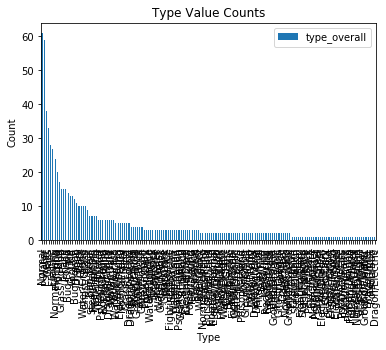

,type_overall
Normal,61
Water,59
Psychic,38
Grass,33
Fire,28
Electric,27
Normal/Flying,24
Fighting,20
Bug,17
Grass/Poison,15


In [13]:
# Create column for overall pokemon type
pokemon_df['type_overall'] = np.where(pokemon_df['type_1'] != pokemon_df['type_2'], \
                    pokemon_df['type_1'] + '/' + pokemon_df['type_2'], pokemon_df['type_1'])

print('Number of unique pokemon typing:', \
      len(pokemon_df['type_overall'].value_counts()))

# Create bar chart of value counts
pokemon_df['type_overall'].value_counts().to_frame().plot(kind='bar')
plt.xlabel('Type')
plt.ylabel('Count')
plt.title('Type Value Counts')
plt.show()

# Top 20 pokemon typing
pokemon_df['type_overall'].value_counts().to_frame().head(20)

Common typing seems to be single types.

In [14]:
# Generation value counts
pokemon_df['generation'].value_counts().to_frame()

,generation
1,166
5,165
3,160
4,121
2,106
6,82


Looks to be a downward trend on new pokemon in the later generations. This makes sense as pokemon from older generations are recycled into the new generation in the games.

In [15]:
# Change legendary column to binary
pokemon_df['legendary'].map(lambda x: 1 if x == True else 0)

print('Number of legendaries: ', sum(pokemon_df['legendary']))

Number of legendaries:  65


In [16]:
# Legendary summary stats 
sum_stats_leg = pokemon_df[pokemon_df['legendary']==1].describe()[sum_stats.columns]
sum_stats_leg

,hp,attack,defense,sp_atk,sp_def,speed
count,65.000000,65.000000,65.000000,65.000000,65.000000,65.000000
mean,92.738462,116.676923,99.661538,122.184615,105.938462,100.184615
std,21.722164,30.348037,28.255131,31.104608,28.827004,22.952323
min,50.000000,50.000000,20.000000,50.000000,20.000000,50.000000
25%,80.000000,100.000000,90.000000,100.000000,90.000000,90.000000
50%,91.000000,110.000000,100.000000,120.000000,100.000000,100.000000
75%,105.000000,131.000000,115.000000,150.000000,120.000000,110.000000
max,150.000000,190.000000,200.000000,194.000000,200.000000,180.000000


In [17]:
# Non-legendary summary stats
sum_stats_norm = pokemon_df[pokemon_df['legendary']==0].describe()[sum_stats.columns]
sum_stats_norm

,hp,attack,defense,sp_atk,sp_def,speed
count,735.000000,735.000000,735.000000,735.000000,735.000000,735.000000
mean,67.182313,75.669388,71.559184,68.454422,68.892517,65.455782
std,24.808849,30.490153,30.408194,29.091705,25.669310,27.843038
min,1.000000,5.000000,5.000000,10.000000,20.000000,5.000000
25%,50.000000,54.500000,50.000000,45.000000,50.000000,45.000000
50%,65.000000,72.000000,66.000000,65.000000,65.000000,64.000000
75%,79.500000,95.000000,85.000000,85.000000,85.000000,85.000000
max,255.000000,185.000000,230.000000,175.000000,230.000000,160.000000


In [18]:
# Delta between all pokemon summary stats and legendary summary stats
sum_stats_leg - sum_stats_norm

,hp,attack,defense,sp_atk,sp_def,speed
count,-670.000000,-670.000000,-670.000000,-670.000000,-670.000000,-670.000000
mean,25.556149,41.007535,28.102355,53.730194,37.045945,34.728833
std,-3.086685,-0.142115,-2.153064,2.012903,3.157693,-4.890715
min,49.000000,45.000000,15.000000,40.000000,0.000000,45.000000
25%,30.000000,45.500000,40.000000,55.000000,40.000000,45.000000
50%,26.000000,38.000000,34.000000,55.000000,35.000000,36.000000
75%,25.500000,36.000000,30.000000,65.000000,35.000000,25.000000
max,-105.000000,5.000000,-30.000000,19.000000,-30.000000,20.000000


Legendary pokemon have a significant stat bump from the rest of the pokemon- especially in the attack stats.<br/><br/>
Let's now join the 2 dataframes we have.

In [19]:
# First make 3 copies of the pokemon_df dataframe
df_1 = pokemon_df.copy()
df_2 = pokemon_df.copy()
df_w = pokemon_df.copy()

# Rename the columns to be able to index by first, second, and winner
df_1.columns = [col + '_1' for col in pokemon_df.columns]
df_2.columns = [col + '_2' for col in pokemon_df.columns]
df_w.columns = [col + '_w' for col in pokemon_df.columns]

# Merge the 3 dataframes together
join_1 = pd.merge(combat_df, df_1, left_on='First_pokemon', right_on='#_1')
join_2 = pd.merge(join_1, df_2, left_on='Second_pokemon', right_on='#_2')
connected_df = pd.merge(join_2, df_w[['#_w', 'name_w', 'type_overall_w']], left_on='Winner', right_on='#_w')

connected_df.head()

,First_pokemon,Second_pokemon,Winner,#_1,name_1,type_1_1,type_2_1,hp_1,attack_1,defense_1,...,defense_2,sp_atk_2,sp_def_2,speed_2,generation_2,legendary_2,type_overall_2,#_w,name_w,type_overall_w
0,266,298,298,266,Larvitar,Rock,Ground,50,64,50,...,40,60,40,60,3,False,Grass/Dark,298,Nuzleaf,Grass/Dark
1,73,298,298,73,Machop,Fighting,Fighting,70,80,50,...,40,60,40,60,3,False,Grass/Dark,298,Nuzleaf,Grass/Dark
2,373,298,298,373,Whiscash,Water,Ground,110,78,73,...,40,60,40,60,3,False,Grass/Dark,298,Nuzleaf,Grass/Dark
3,659,298,298,659,Ferroseed,Grass,Steel,44,50,91,...,40,60,40,60,3,False,Grass/Dark,298,Nuzleaf,Grass/Dark
4,517,298,298,517,Tangrowth,Grass,Grass,100,100,125,...,40,60,40,60,3,False,Grass/Dark,298,Nuzleaf,Grass/Dark


Let's do some EDA on which pokemon were likely to win their battle.

In [20]:
# Top 10 pokemon with highest number of wins
connected_df['name_w'].value_counts().to_frame().head(10)

,name_w
Mewtwo,152
Infernape,136
Aerodactyl,136
Jirachi,134
Slaking,133
Deoxys Speed Forme,133
Murkrow,130
Mega Absol,130
Mega Houndoom,128
Mega Aerodactyl,127


In [21]:
# Bottom 10 pokemon with lowest number of wins
connected_df['name_w'].value_counts().to_frame().tail(10)

,name_w
Cleffa,7
Cascoon,7
Wynaut,6
Wooper,6
Igglybuff,5
Munna,5
Slugma,4
Solosis,4
Silcoon,3
Togepi,3


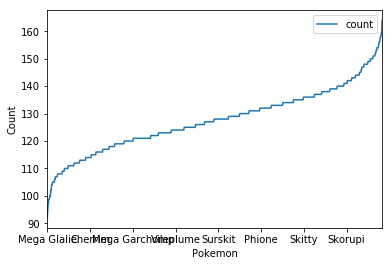

In [22]:
# See if there's any pokemon overly or underly present in the matches
present_1 = connected_df['name_1'].value_counts().to_frame().reset_index()
present_2 = connected_df['name_2'].value_counts().to_frame().reset_index()

present_df = pd.merge(present_1, present_2, left_on='index', right_on='index')
present_df['count'] = present_df['name_1'] + present_df['name_2']

present_df.sort_values('count').plot('index', 'count')
plt.xlabel('Pokemon')
plt.ylabel('Count')

There isn't an even distribution, but with the lower end at ~105 and higher end ~155 it doesn't look too unbalanced.<br/><br/> 
Now to see the most likely winning pokemon types.

In [23]:
# Top 10 winning types
connected_df['type_overall_w'].value_counts().to_frame().head(10)

,type_overall_w
Normal,3845
Water,3376
Psychic,2404
Electric,2077
Fire,1935
Normal/Flying,1867
Grass,1669
Bug/Flying,1076
Fighting,988
Dark,856


In [24]:
# Bottom 10 losing types
connected_df['type_overall_w'].value_counts().to_frame().tail(10)

,type_overall_w
Water/Ghost,42
Bug/Ghost,41
Rock/Grass,41
Grass/Ground,39
Electric/Dragon,37
Poison/Dragon,31
Ghost/Dark,29
Ground/Electric,29
Poison/Water,14
Fire/Rock,9


We should also consider the 'type battles won' as a representation of how many of those types were in previous battles. In other words, did 'Fire/Rock' win 9 battles out of a total 9 battles? That would make their winning rate 100%!

In [25]:
# Count of pokemon types
total_type = [tpe for tpe in connected_df['type_overall_1']]
for tpe in connected_df['type_overall_2']:
    total_type.append(tpe)

# Create dictionary of wins and number of entries for each pokemon type 
type_dct = {}

for tpe in total_type:
    if tpe in type_dct:
        type_dct[tpe]['entries'] = type_dct[tpe]['entries'] + 1
    else:
        type_dct[tpe] = {'entries': 1,
                         'wins': 0}
        
# Add wins
for tpe in connected_df['type_overall_w']:
    type_dct[tpe]['wins'] = type_dct[tpe]['wins'] + 1

# Add percent win
for k, v in type_dct.items():
    type_dct[k]['percent_win'] = round(v['wins'] / v['entries'], 2)
    
# Create list of dictionaries of types, percent wins, and entries
type_dct_list = [{'type': tpe, 'percent_win': type_dct[tpe]['percent_win'],
       'entries': type_dct[tpe]['entries']} for tpe in type_dct.keys()]

# Create dataframe of types, percent wins, and entries
type_win_df = pd.DataFrame(type_dct_list)
type_win_df = type_win_df[['type', 'percent_win', 'entries']]

type_win_df.sort_values('percent_win', ascending=False).head(10)

,type,percent_win,entries
130,Dark/Ice,0.96,232
125,Normal/Fighting,0.96,252
152,Grass/Dragon,0.94,126
136,Flying,0.91,236
151,Steel/Fighting,0.91,128
149,Fighting/Flying,0.88,121
150,Electric/Fairy,0.88,124
153,Psychic/Fire,0.88,131
126,Dragon/Psychic,0.87,366
117,Rock/Flying,0.86,516


So this is interesting. The top 10 count of wins have no overlap with the top 10 wins by percentage of entries. For the top 10 list above, let's see how many unique pokemon have that typing. I suspect it may only be 1 or very few per category.

In [26]:
connected_df.head()

,First_pokemon,Second_pokemon,Winner,#_1,name_1,type_1_1,type_2_1,hp_1,attack_1,defense_1,...,defense_2,sp_atk_2,sp_def_2,speed_2,generation_2,legendary_2,type_overall_2,#_w,name_w,type_overall_w
0,266,298,298,266,Larvitar,Rock,Ground,50,64,50,...,40,60,40,60,3,False,Grass/Dark,298,Nuzleaf,Grass/Dark
1,73,298,298,73,Machop,Fighting,Fighting,70,80,50,...,40,60,40,60,3,False,Grass/Dark,298,Nuzleaf,Grass/Dark
2,373,298,298,373,Whiscash,Water,Ground,110,78,73,...,40,60,40,60,3,False,Grass/Dark,298,Nuzleaf,Grass/Dark
3,659,298,298,659,Ferroseed,Grass,Steel,44,50,91,...,40,60,40,60,3,False,Grass/Dark,298,Nuzleaf,Grass/Dark
4,517,298,298,517,Tangrowth,Grass,Grass,100,100,125,...,40,60,40,60,3,False,Grass/Dark,298,Nuzleaf,Grass/Dark


In [27]:
# Store top 10 percent wins types as list
pwin_top10_types = list(type_win_df.sort_values('percent_win', 
                                     ascending=False).head(10)['type'])

pwin_top10_pokemon = []

# Look at types for first pokemon
for index, row in connected_df.iterrows():
    
    # Look at types for first pokemon
    if row['type_overall_1'] in pwin_top10_types:
        pwin_top10_pokemon.append([row['name_1'], row['type_overall_1']])
        
        # Look at types for second pokemon
        if row['type_overall_2'] in pwin_top10_types:
            pwin_top10_pokemon.append([row['name_2'], row['type_overall_2']])
            
pwin_top10_df = pd.DataFrame(pwin_top10_pokemon, columns=['name', 'type'])

pwin_top10_df.groupby('type').nunique()[['name']]

,name
type,
Dark/Ice,2
Dragon/Psychic,3
Electric/Fairy,1
Fighting/Flying,1
Flying,2
Grass/Dragon,1
Normal/Fighting,2
Psychic/Fire,1
Rock/Flying,4


As expected, only a few pokemon have these favorable typing.

### Preprocessing
Let's do some preprocessing for our modeling now. We'll start by creating our feature matrix and target vector.

In [61]:
# Set up feature matrix and target vector

# We'll exclude type 1 and type 2 and just use type overall for now
X_train = connected_df.drop(['First_pokemon', 'Second_pokemon', 'Winner', \
                     '#_1', 'name_1', '#_2', 'name_2', '#_w', \
                      'name_w', 'type_overall_w', 'type_1_1', \
                      'type_2_1', 'type_1_2', 'type_2_2'], axis=1)

# Create binary target. 1 for winning pokemon being first pokemon. 0
y_train = np.where(connected_df['#_w']==connected_df['#_1'], \
                                       1, 0)

# Create dummy columns for categorical features
X_train = pd.get_dummies(X_train, columns=['type_overall_1', 'type_overall_2'])

We also need to run the preprocessing on the test file provided on Kaggle.

In [68]:
# Import test file into pandas dataframe
test_df = pd.read_csv('./dataset/test.csv')

# Merge pokemon data 
join_1 = pd.merge(test_df, df_1, left_on='First_pokemon', \
                              right_on='#_1')
connected_df_test = pd.merge(join_1, df_2, left_on='Second_pokemon', \
                             right_on='#_2')

# Drop unneeded columns
X_test = connected_df_test.drop(['First_pokemon', 'Second_pokemon', \
                           '#_1', 'name_1', '#_2', 'name_2', 'type_1_1', \
                           'type_2_1', 'type_1_2', 'type_2_2'], axis=1)

# Dummify categorical features
X_test = pd.get_dummies(X_test, columns=['type_overall_1', 'type_overall_2'])

# See head of test feature matrix
X_test.head()

,hp_1,attack_1,defense_1,sp_atk_1,sp_def_1,speed_1,generation_1,legendary_1,hp_2,attack_2,...,type_overall_2_Water/Fighting,type_overall_2_Water/Flying,type_overall_2_Water/Ghost,type_overall_2_Water/Grass,type_overall_2_Water/Ground,type_overall_2_Water/Ice,type_overall_2_Water/Poison,type_overall_2_Water/Psychic,type_overall_2_Water/Rock,type_overall_2_Water/Steel
0,80,92,65,65,80,68,1,False,90,55,...,0,0,0,0,0,0,0,0,0,0
1,30,40,55,40,55,60,3,False,90,55,...,0,0,0,0,0,0,0,0,0,0
2,70,150,140,65,100,75,2,False,90,55,...,0,0,0,0,0,0,0,0,0,0
3,50,50,95,40,50,35,1,False,90,55,...,0,0,0,0,0,0,0,0,0,0
4,78,84,78,109,85,100,2,False,90,55,...,0,0,0,0,0,0,0,0,0,0


Because we've made our y a binary target, we need a way to reconvert it back to the appropriate pokemon index number for prediction submissions.

In [104]:
def predict_pokemon(X, estimator):
    '''This function predicts on a given feature matrix and concatenates
    the currently defined test_df with its predictions. The second
    parameter is the estimator.'''

    estimator.fit(X_train, y_train)
    pred = pd.DataFrame(estimator.predict(X), columns=['prediction'])
    
    pred_df = pd.concat([test_df, pred], axis=1)
    
    for _, row in pred_df.iterrows():
        if row['prediction'] == 1:
            row['prediction'] = row['First_pokemon']
        else:
            row['prediction'] = row['Second_pokemon']
    
    return pred_df

### Modeling
Let's start off by using an ensembled tree.

In [38]:
rfc = RandomForestClassifier()

# Cross val score with 10 folds
cross_val_score(rfc, X_train, y_train, cv=10).mean()

0.77875686567267466

To start off the bat we have a cross validated accuracy score of ~77.88, so not too bad! 

In [110]:
rfc_prediction = predict_pokemon(X_test, rfc)
rfc_prediction.head()

,First_pokemon,Second_pokemon,prediction
0,129,117,129
1,660,211,660
2,706,115,706
3,195,618,618
4,27,656,27
